# Multi-Layer Perceptron
In this Jupyter Notebook, we code a Multi-Layer Perceptron (MLP) for classification and regression tasks using Stochastic Gradient Descent for training the model. The MLP would be able to perform multiclass as well as binary classification. <br>

The model would also allow customization of activation function used, as well as training schedule for optimization purposes. The MLP is designed with a single hidden layer architecture. <br>

This notebook is dvided into three sections
1. Section 1 - Helper functions and multiclass classification
1. Section 2 - Binary classification
1. Section 3 - Regression

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import itertools
import math
from math import exp
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

## Section 1

### 1. Implement the following function that creates a weight matrix and initializes it with small random real numbers.

In [2]:
def initializeWeights(input_neurons,output_neurons):
    W = np.random.randn(input_neurons,output_neurons) * 0.01
    return W

### 2. Implement the logistic sigmoid activation function.

In [3]:
def logistic(z):
    return 1/(1+np.exp(-z))

### 3. Implement the ReLU (rectified linear unit) activation function.

In [4]:
def relu(z):
    return np.maximum(0,z) 

### 4. Implement the tanh (hyperbolic tangent) activation function.

In [5]:
def tanh(z):
    return np.tanh(z)

### 5. Implement a MLP Classifier model class for performing multi-class classification.

### The MLP Classifier has a single hidden layer. It should have the following four methods.The model uses the back-propagation algorithm for learning the weights of the features/neurons. Note the that “fit” method should implement the Stochastic Gradient Descent algorithm for optimizing the weight update process.

In [6]:
'''
Helper functions for the derivative of activation functions
'''
def d_logistic(z):
    dz = logistic(z) * (1 - logistic(z))
    return dz

def d_tanh(z):
    dz = (1-np.power(np.tanh(z),2))
    return dz

def d_relu(z):
    dz = np.where(z==0,0,1)
    return dz
    

In [7]:
'''
Helper function for one_hot_labels
Input:
    Y - target vector
Output:
    one_hot_matrix
'''
def one_hot_labels(Y):
    
    # Get unique labels in Y and number of observations
    unique_labels = np.unique(Y)
    n = len(Y)
    
    # Create one hot matrix
    labels = np.array(list(unique_labels)).reshape(len(unique_labels),1)
    one_hot_matrix = np.apply_along_axis(lambda x: np.full((n,),x),1,labels)
    one_hot_matrix = np.apply_along_axis(lambda x: (x==Y).astype(int),1,one_hot_matrix).T
    
    return one_hot_matrix

In [8]:
'''
Helper function for softmax calculation
Given matrix A (output from hidden layer), outputs probabilties   
'''
def softmax(A):
    A = np.apply_along_axis(np.exp,0,A)
    A = np.apply_along_axis(lambda x: x/(sum(x)),1,A)
    return A

### 6. Read the handwritten digits datasetusing the sklearn.datasets.load_digits function for performing multi-class classification.

In [29]:
digits = datasets.load_digits()
X = digits.data
y= digits.target
X,y = shuffle(X,y)

### 7. Partition the data into train and test set. Use the “Partition” function from your previous assignment or from sklearn.

In [30]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

### 8. Standardize the features.

In [31]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### 9. Hyperparameter tuning based on certain fixed-values hyperparameters.

### 10. Report on performance of model.

## Section 2

### 11. Implement binary classification module in theMLPClassifier. Then, performbinary classification on the handwritten digits dataset to recognize the digits “5” and “not-5”.

In [12]:
def binary_cross_entropy(Y,Y_proba):
    loss=-(np.dot(Y,np.log(Y_proba))+np.dot((1-Y),np.log((1-Y_proba))))/Y.shape[0]
    return loss

def binary_cross_entropy_l2(Y,Y_proba,Theta_1,Theta_2,lambd):
    loss=-(np.dot(Y,np.log(Y_proba))+np.dot((1-Y),np.log((1-Y_proba))))/Y.shape[0]+ 0.5*lambd*np.sum(np.square(Theta_1[1:]))+ 0.5*lambd*np.sum(np.square(Theta_2[1:]))
    return loss

def cross_entropy(Y_one_hot, Y_proba):
    loss = -np.sum(np.multiply(Y_one_hot,np.log(Y_proba)))/Y_one_hot.shape[0]
    return loss

def cross_entropy_l2(Y_one_hot, Y_proba, Theta_1, Theta_2, lambd):
    loss = cross_entropy(Y_one_hot, Y_proba) + 0.5*lambd*np.sum(np.square(Theta_1[1:]))+ 0.5*lambd*np.sum(np.square(Theta_2[1:]))
    return loss

In [13]:
def timeBasedDecay(initial_eta,decay,iteration):
    eta = initial_eta * (1 / (1 + decay * iteration))
    return eta
def exponentialDecay(initial_eta,decay,iteration):
    eta = initial_eta * np.exp(-decay*iteration)
    return eta


In [14]:
 # Forward Propogation
def Forward_prop(Xi,W_1,W_2,activation='logistic',classifier='binary'):
    
    x_0 = np.ones((Xi.shape[0],1))
    a1 = np.concatenate((x_0,Xi), axis=1)
    z2 =np.dot(a1,W_1) 
    if activation =='logistic':
        a2 = logistic(z2)
                    
    elif activation =='relu':
        a2 = relu(z2)
                    
    elif activation == 'tanh':
        a2 = tanh(z2)
    
    x_0 = np.ones((a2.shape[0],1))
    a2 = np.concatenate((x_0,a2), axis=1)              
    
    z3 =np.dot(a2,W_2)
                
    if classifier =='binary':
        a3 = logistic(z3)
               
    elif classifier =='multi':
        a3 = softmax(z3)
        
    return a1,z2,a2,z3,a3    
                    

In [15]:
# Backward Propogation
def Backward_prop(Xi,Yi,W_2,z2,z3,a3,activation='logistic',classifier='binary'):
  
    if classifier =='binary':
        d_activ_z3 = d_logistic(z3)
        
        if Yi==1:
            delta_3 = -(1/a3) * d_activ_z3
            
        elif Yi==0:
            delta_3 = (1/(1-a3)) * d_activ_z3
                        
    elif classifier =='multi':
        delta_3 = (a3 - Yi)
                          
    if activation =='logistic':
        d_activ_z2 = d_logistic(z2)
                    
    elif activation =='relu':
        d_activ_z2 = d_relu(z2)
                    
    elif activation == 'tanh':
        d_activ_z2 = d_tanh(z2)
                    
    delta_2 = np.dot(delta_3,(W_2[1:]).T)*d_activ_z2
    return delta_2,delta_3            

In [16]:
 # Forward Propogation
def predict_proba(Xi,W_1,W_2,activation='logistic',classifier='binary'):
    
    x_0 = np.ones((Xi.shape[0],1))
    a1 = np.concatenate((x_0,Xi), axis=1)
    z2 =np.dot(a1,W_1) 
    if activation =='logistic':
        a2 = logistic(z2)
                    
    elif activation =='relu':
        a2 = relu(z2)
                    
    elif activation == 'tanh':
        a2 = tanh(z2)
    
    x_0 = np.ones((a2.shape[0],1))
    a2 = np.concatenate((x_0,a2), axis=1)              
    
    z3 =np.dot(a2,W_2)
                
    if classifier =='binary':
        a3 = logistic(z3)
               
    elif classifier =='multi':
        a3 = softmax(z3)
        
    return a3    
                    

In [17]:
# Write a function for predicting the labels based on the predictd probabilities
def predict_labels(y_pred_proba,classifier='binary'):
    
    if classifier=='binary':
        y_predicted = np.array(list(map(lambda x: 1 if x>0.5 else 0, y_pred_proba)))
        
    elif classifier=='multi':
        y_predicted = np.argmax(y_pred_proba, axis=1)
        
    return y_predicted

In [18]:
"""
Calculates the accuracy between the true and predicted labels
Input: 
    true: array_like type vector of true labels
    pred: array_like type vector of predicted labels
Output:
    accuracy: accuracy expressed in decimal
"""
def accuracy_calc(true, pred):
    accuracy= np.mean(true == pred)
    return accuracy

In [19]:
class MLPClassifier():
    def __init__(self, hidden_layer_neurons=2, activation= 'logistic', regularizer=None, 
                 alpha=0.0001, learning_rate='constant', learning_rate_scheduler='timeBasedDecay',learning_rate_init=0.001, 
                 tol = 0.0001, early_stopping=False, n_iter_no_change=10, momentum=False, beta=0.9, lambda_plateau=0.5, **kwargs):
        self.hidden_layer_neurons = hidden_layer_neurons
        self.activation = activation
        self.regularizer = regularizer
        self.tol = tol
        self.alpha = alpha
        self.beta = beta
        self.W_1 = None
        self.W_2= None
        self.learning_rate_init = learning_rate_init
        self.learning_rate = learning_rate
        self.lambda_plateau = lambda_plateau #lambda is value between 0 and 1 to reduce eta during plateau
        self.learning_rate_scheduler = learning_rate_scheduler
        self.loss_train = []
        self.loss_validation = []
        self.accuracy_train = []
        self.accuracy_validation = []
        self.early_stopping = early_stopping
        self.n_iter_no_change = n_iter_no_change
        self.momentum = momentum
        self.classifier = []
        
        if "Decay" in kwargs:
            self.decay = kwargs["Decay"]
        return
    
    def fit(self, X, Y, validation_fraction=0.1, max_iter=1000, verbose=False,**kwargs):
        
        unique_labels = np.unique(Y)
        if len(unique_labels)>2:
            classifier = 'multi'
            self.classifier = classifier
            Y = one_hot_labels(Y)
            output_layer_neurons = len(unique_labels)
        else:
            classifier = 'binary'
            self.classifier = classifier
            output_layer_neurons = 1

        #Extract number of input layer neurons (excluding bias)    
        input_layer_neurons = X.shape[1]
        
        valid_samples = math.floor(X.shape[0]*validation_fraction)
        validation_X = X[:valid_samples]
        X = X[valid_samples:]
        validation_Y = Y[:valid_samples]
        Y = Y[valid_samples:]
        
        # Set number of training data
        n = X.shape[0]        
        
        #Weights Initialization
        self.W_1 = initializeWeights(input_layer_neurons+1, self.hidden_layer_neurons) 
        self.W_2 = initializeWeights(self.hidden_layer_neurons+1, output_layer_neurons)
        
        iteration=0
        
        for epoch in range(max_iter):
            loss = []
            accu = []
            for i in range(n):
                iteration = iteration +1
                random_index = np.random.randint(n)
                Yi=Y[random_index:random_index+1]
                Xi=X[random_index:random_index+1]
              
                if self.learning_rate == 'constant':
                    eta = self.learning_rate_init
                    
                if self.learning_rate == 'adaptive':
                    if self.learning_rate_scheduler == 'timeBasedDecay':
                        eta=timeBasedDecay(self.learning_rate_init,self.decay,iteration)
                    elif self.learning_rate_scheduler == 'exponentialDecay':
                        eta=exponentialDecay(self.learning_rate_init,self.decay,iteration)
                    elif self.learning_rate_scheduler == 'reduceLearningRateOnPlateau':
                        if epoch > self.n_iter_no_change:
                            count = 0
                            temp = self.accuracy_validation[-self.n_iter_no_change:]
                            for j in range(len(temp)-1):
                                if (temp[j+1]-temp[j]) < self.tol:
                                    count= count+1
                            if count == self.n_iter_no_change-1:        
                                eta = self.learning_rate_init*self.lambda_plateau
                                    
        
                a1,z2,a2,z3,a3 = Forward_prop(Xi,self.W_1,self.W_2,activation=self.activation,classifier=classifier)
                
                delta_2,delta_3 = Backward_prop(Xi,Yi,self.W_2,z2,z3,a3,activation=self.activation,classifier=classifier)
               
                if classifier =='binary':
                    y_pred=predict_labels(a3,classifier=classifier)
                    acc=accuracy_calc(Yi,y_pred)
                # Compute the loss using Cross Entropy
                    if self.regularizer=='l2':
                        L = binary_cross_entropy_l2(Yi,a3,self.W_1,self.W_2,self.alpha) 
                    else:
                        L = binary_cross_entropy(Yi,a3) 
                        
                elif classifier =='multi':
                    y_pred=predict_labels(a3,classifier=classifier)
                    y_true=np.argmax(Yi, axis=1)
                    acc=accuracy_calc(y_true,y_pred)
                    if self.regularizer=='l2':
                        L = cross_entropy_l2(Yi,a3,self.W_1,self.W_2,self.alpha) 
                    else:
                        L = cross_entropy(Yi,a3) 
                # Store the training loss in a list
                loss.append(L)
                accu.append(acc)
                
                # Gradient Computation and Weight Updates
                if self.regularizer == 'l2':
                    regularized_term_1 = self.alpha*self.W_1
                    regularized_term_1[0] = 0  # Exclude the bias term
                    regularized_term_2 = self.alpha*self.W_2
                    regularized_term_2[0] = 0  # Exclude the bias term
                    grad_L_for_W_2 = np.dot(a2.T,delta_3) + regularized_term_2
                    grad_L_for_W_1 = np.dot(a1.T,delta_2) + regularized_term_1
                else:
                    grad_L_for_W_2 = np.dot(a2.T,delta_3)
                    grad_L_for_W_1 = np.dot(a1.T,delta_2)
                
                if self.momentum is True:
                    if epoch == 0:
                        m_t1_1 = np.zeros((grad_L_for_W_1.shape[0],grad_L_for_W_1.shape[1]))
                        m_t2_1 = np.zeros((grad_L_for_W_2.shape[0],grad_L_for_W_2.shape[1]))
                    
                    m_1 = self.beta*m_t1_1 - eta*grad_L_for_W_1
                    m_2 = self.beta*m_t2_1 - eta*grad_L_for_W_2
                    
                    self.W_2 = self.W_2 + m_2 
                    self.W_1 = self.W_1 + m_1
                    
                    m_t1_1 = m_1
                    m_t2_1 = m_2
                
                else:
                    self.W_2 = self.W_2 - eta* grad_L_for_W_2 
                    self.W_1 = self.W_1 - eta* grad_L_for_W_1
                
            self.loss_train.append(np.mean(loss))
            self.accuracy_train.append(np.mean(accu)) 
            
            
            
            if classifier =='binary':
                y_pred_proba = predict_proba(validation_X,self.W_1,self.W_2,activation=self.activation,classifier=classifier)
                y_pred = predict_labels(y_pred_proba,classifier=classifier)
                acc = accuracy_calc(validation_Y,y_pred)
                if self.regularizer=='l2':
                    L = binary_cross_entropy_l2(validation_Y,y_pred_proba,self.W_1,self.W_2,self.alpha) 
                else:
                    L = binary_cross_entropy(validation_Y,y_pred_proba) 
                            
            elif classifier =='multi':
                y_pred_proba = predict_proba(validation_X,self.W_1,self.W_2,activation=self.activation,classifier=classifier)
                y_pred = predict_labels(y_pred_proba,classifier=classifier)
                y_true=np.argmax(validation_Y, axis=1)
                acc = accuracy_calc(y_true,y_pred)
                if self.regularizer=='l2':
                    L = cross_entropy_l2(validation_Y,y_pred_proba,self.W_1,self.W_2,self.alpha) 
                else:
                    L = cross_entropy(validation_Y,y_pred_proba) 
            
            self.loss_validation.append(L)
            self.accuracy_validation.append(acc) 
            if verbose is True:
                print("\nEpoch %d of %d: Train Loss = %f | Val Loss = %f | Train Acc = %f | Val Acc = %f | Eta = %f" %(epoch,max_iter,self.loss_train[epoch],self.loss_validation[epoch],self.accuracy_train[epoch],self.accuracy_validation[epoch],eta))

            if self.early_stopping is True:
                if epoch > self.n_iter_no_change:
                    temp = self.accuracy_validation[-self.n_iter_no_change:]
                    count=0
                    for j in range(len(temp)-1):
                        if (temp[j+1]-temp[j]) < self.tol:
                            count= count+1
                    if count==self.n_iter_no_change-1:
                        print("\nEarly Stopping because the validation accuracy change between two consecutive epochs is less than %f over the last %d iterations" %(self.tol,self.n_iter_no_change))
                        break
        
            
    
    def  predict(self, X):
        y_pred_proba = predict_proba(X,self.W_1,self.W_2,activation=self.activation,classifier=self.classifier)
        y_pred = predict_labels(y_pred_proba,classifier=self.classifier)
        return y_pred
    
    def plotLearningCurve(self):
        # Plotting Learning Curve            
        epochs_xaxis=np.linspace(1.0,len(self.loss_train),num=len(self.loss_train))
        plt.figure(figsize=(12, 9), dpi=80)
        plt.subplot(1, 2, 1)
        plt.plot(epochs_xaxis,self.loss_train,"r--", alpha=1.0, linewidth=3.0, label = "Training")
        plt.plot(epochs_xaxis,self.loss_validation,"b-", alpha=1.0, linewidth=3.0, label = "Validation")
        plt.xlabel("Epochs")
        plt.ylabel("Average Loss")
        plt.title("Loss VS Epochs")
        plt.legend()
        
        epochs_xaxis=np.linspace(1.0,len(self.loss_train),num=len(self.loss_train))
        plt.figure(figsize=(12, 9), dpi=80)
        plt.subplot(1, 2, 2)
        plt.plot(epochs_xaxis,self.accuracy_train,"r--", alpha=1.0, linewidth=3.0, label = "Training")
        plt.plot(epochs_xaxis,self.accuracy_validation,"b-", alpha=1.0, linewidth=3.0, label = "Validation")
        plt.xlabel("Epochs")
        plt.ylabel("Average Accuracy")
        plt.title("Accuracy VS Epochs")
        plt.legend()
        plt.show()
        
  
        

In [24]:
m=MLPClassifier(hidden_layer_neurons=25, activation= 'logistic', regularizer='l2', 
                 alpha=0.0001, learning_rate='constant', learning_rate_scheduler='timeBasedDecay',learning_rate_init=0.001, 
                 tol = 0.0001, early_stopping=True, n_iter_no_change=10, momentum=True, beta=0.9, lambda_plateau=0.5, Decay = 0.001)

In [25]:
m.fit(X_train, y_train, validation_fraction=0.1, max_iter=1000, verbose=True)


Epoch 0 of 1000: Train Loss = 2.300672 | Val Loss = 2.315280 | Train Acc = 0.119011 | Val Acc = 0.097902 | Eta = 0.001000

Epoch 1 of 1000: Train Loss = 2.293620 | Val Loss = 2.247079 | Train Acc = 0.136785 | Val Acc = 0.188811 | Eta = 0.001000

Epoch 2 of 1000: Train Loss = 1.935646 | Val Loss = 1.696433 | Train Acc = 0.430448 | Val Acc = 0.552448 | Eta = 0.001000

Epoch 3 of 1000: Train Loss = 1.231086 | Val Loss = 1.140355 | Train Acc = 0.737249 | Val Acc = 0.699301 | Eta = 0.001000

Epoch 4 of 1000: Train Loss = 0.795520 | Val Loss = 0.888794 | Train Acc = 0.829985 | Val Acc = 0.734266 | Eta = 0.001000

Epoch 5 of 1000: Train Loss = 0.604051 | Val Loss = 0.714743 | Train Acc = 0.875580 | Val Acc = 0.825175 | Eta = 0.001000

Epoch 6 of 1000: Train Loss = 0.475311 | Val Loss = 0.565094 | Train Acc = 0.901082 | Val Acc = 0.874126 | Eta = 0.001000

Epoch 7 of 1000: Train Loss = 0.358406 | Val Loss = 0.485180 | Train Acc = 0.938949 | Val Acc = 0.881119 | Eta = 0.001000

Epoch 8 of 1000

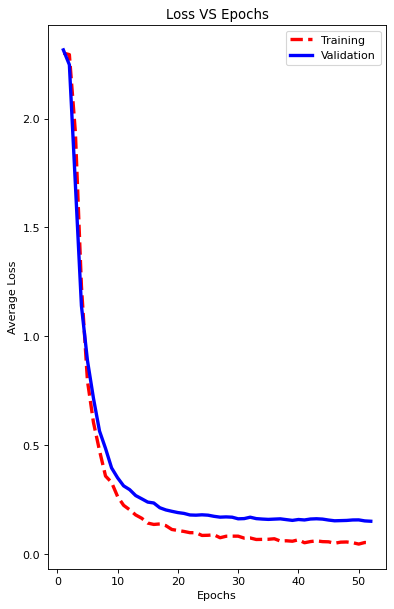

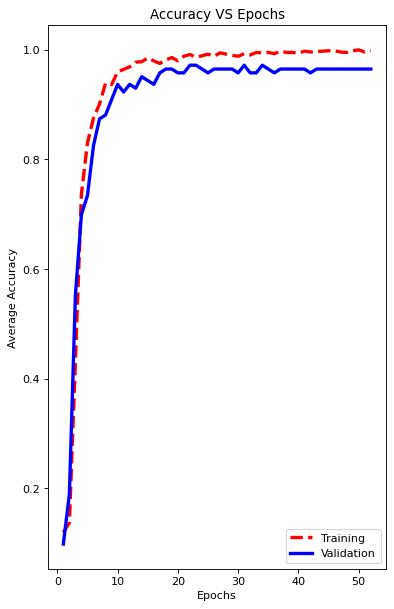

In [26]:
m.plotLearningCurve()

In [27]:
y_pred=m.predict(X_test)
accuracy_calc(y_test,y_pred)

0.9638888888888889

In [62]:
digits = datasets.load_digits()
X_binary = digits.data
y_binary = digits.target
y_binary = np.array(list(map(lambda x: 1 if x==5 else 0, y_binary)))
X_binary,y_binary = shuffle(X_binary,y_binary)
X_train_binary,X_test_binary,y_train_binary,y_test_binary = train_test_split(X_binary,y_binary,test_size=0.2)

In [63]:
scaler = StandardScaler()
scaler.fit(X_train_binary)
X_train_binary = scaler.transform(X_train_binary)
X_test_binary = scaler.transform(X_test_binary)

In [64]:
exists = 1 in y_train_binary
print(exists)

True


In [91]:
m1=MLPClassifier(hidden_layer_neurons=25, activation= 'logistic', regularizer='l2', 
                 alpha=0.001, learning_rate='adaptive', learning_rate_scheduler='timeBasedDecay',learning_rate_init=0.01, 
                 tol = 0.0001, early_stopping=True, n_iter_no_change=10, momentum=True, beta=0.9, lambda_plateau=0.5, Decay =0.001)

In [92]:
m1.fit(X_train_binary, y_train_binary, validation_fraction=0.1, max_iter=1000, verbose=True)


Epoch 0 of 1000: Train Loss = 0.341075 | Val Loss = 0.293002 | Train Acc = 0.885626 | Val Acc = 0.895105 | Eta = 0.004359

Epoch 1 of 1000: Train Loss = 0.176074 | Val Loss = 0.132710 | Train Acc = 0.913447 | Val Acc = 0.916084 | Eta = 0.002787

Epoch 2 of 1000: Train Loss = 0.102987 | Val Loss = 0.091069 | Train Acc = 0.965224 | Val Acc = 0.993007 | Eta = 0.002048

Epoch 3 of 1000: Train Loss = 0.071206 | Val Loss = 0.081453 | Train Acc = 0.986090 | Val Acc = 0.993007 | Eta = 0.001619

Epoch 4 of 1000: Train Loss = 0.056146 | Val Loss = 0.075221 | Train Acc = 0.995363 | Val Acc = 0.993007 | Eta = 0.001339

Epoch 5 of 1000: Train Loss = 0.058543 | Val Loss = 0.072642 | Train Acc = 0.991499 | Val Acc = 0.986014 | Eta = 0.001141

Epoch 6 of 1000: Train Loss = 0.059760 | Val Loss = 0.071007 | Train Acc = 0.991499 | Val Acc = 0.986014 | Eta = 0.000994

Epoch 7 of 1000: Train Loss = 0.052048 | Val Loss = 0.068871 | Train Acc = 0.992272 | Val Acc = 0.986014 | Eta = 0.000881

Epoch 8 of 1000

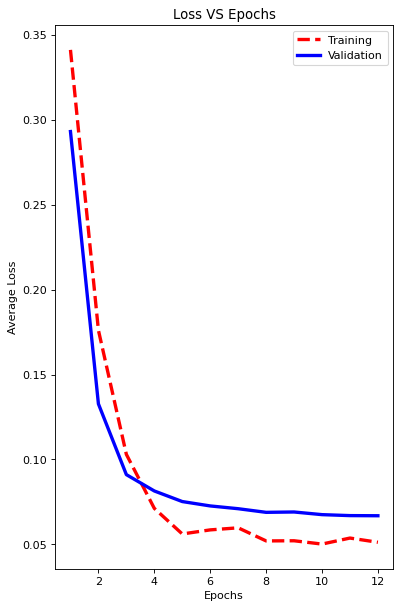

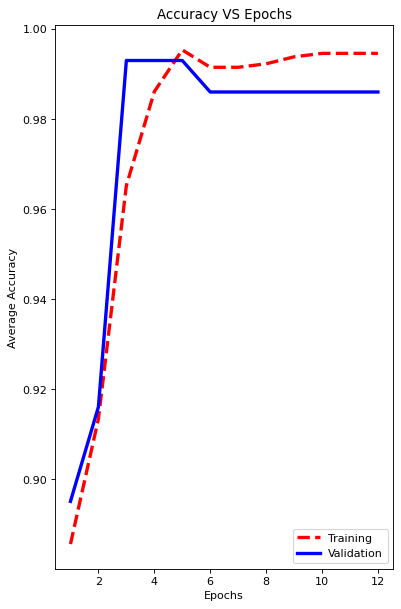

In [93]:
m1.plotLearningCurve()

In [94]:
y_pred=m1.predict(X_test_binary)
accuracy_calc(y_test_binary,y_pred)

0.9944444444444445

In [95]:
count = np.count_nonzero(y_pred == 1)
count

31

In [96]:
count = np.count_nonzero(y_test_binary== 1)
count


33

In [84]:
np.array(m1.loss_validation).shape

(12, 1)

### (i) Hyperparameter tuning based on certain fixed-values hyperparameters

### (ii) Report performance on model.

## Section 3 (Extra Credit)

### 12. Implement a Multi-Layer Perceptron regressor model (a MLP Regressor class) with a single hidden layer. The model implements the backpropagation algorithm. To optimize the process of updating the weight matrices, it uses the Stochastic Gradient Descent (SGD) algorithm with momentum.

In [97]:
df = pd.read_csv('./Data/winequality-red.csv', sep=';')

In [98]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [99]:
df = df.sample(frac=1)

In [100]:
Xr = np.array(df.drop(columns=['quality'],axis=1))
yr = np.array(df['quality'])
yr=np.reshape(yr,(len(yr),1))

In [101]:
Xr_train,Xr_test,yr_train,yr_test = train_test_split(Xr,yr,test_size=0.2)
scaler = StandardScaler()
scaler.fit(Xr_train)
Xr_train = scaler.transform(Xr_train)
Xr_test = scaler.transform(Xr_test)

In [102]:
"""
Calculates the mean squared error (mse) between the true and predicted labels
Input: 
    true: array_like type vector of true labels
    pred: array_like type vector of predicted labels
Output:
    mean squared error: accuracy expressed in decimal
"""
def MSE(true,pred):
    diff = true - pred
    error = 0.5*np.sum(np.square(diff))/true.shape[0]
    return error

def MSE_l2(true,pred,Theta_1, Theta_2, lambd):
    diff = true - pred
    error = MSE(true,pred) +(0.5*lambd*np.sum(np.square(Theta_1[1:]))+ 0.5*lambd*np.sum(np.square(Theta_2[1:])))/true.shape[0]
    return error


In [103]:
 # Forward Propogation
def Forward_prop_reg(Xi,W_1,W_2,activation='logistic'):
    
    x_0 = np.ones((Xi.shape[0],1))
    a1 = np.concatenate((x_0,Xi), axis=1)
    z2 =np.dot(a1,W_1) 
    if activation =='logistic':
        a2 = logistic(z2)
                    
    elif activation =='relu':
        a2 = relu(z2)
                    
    elif activation == 'tanh':
        a2 = tanh(z2)
    
    x_0 = np.ones((a2.shape[0],1))
    a2 = np.concatenate((x_0,a2), axis=1)              
    
    z3 =np.dot(a2,W_2)
    a3=z3
    
    return a1,z2,a2,z3,a3 

In [104]:
# Backward Propogation
def Backward_prop_reg(Xi,Yi,W_2,z2,z3,a3,activation='logistic'):
  
    delta_3 = (a3 - Yi)
                          
    if activation =='logistic':
        d_activ_z2 = d_logistic(z2)
                    
    elif activation =='relu':
        d_activ_z2 = d_relu(z2)
                    
    elif activation == 'tanh':
        d_activ_z2 = d_tanh(z2)
                    
    delta_2 = np.dot(delta_3,(W_2[1:]).T)*d_activ_z2
    return delta_2,delta_3 

In [105]:
 # Forward Propogation
def predict_reg(Xi,W_1,W_2,activation='logistic'):
    
    x_0 = np.ones((Xi.shape[0],1))
    a1 = np.concatenate((x_0,Xi), axis=1)
    z2 =np.dot(a1,W_1) 
    if activation =='logistic':
        a2 = logistic(z2)
                    
    elif activation =='relu':
        a2 = relu(z2)
                    
    elif activation == 'tanh':
        a2 = tanh(z2)
    
    x_0 = np.ones((a2.shape[0],1))
    a2 = np.concatenate((x_0,a2), axis=1)              
    
    z3 =np.dot(a2,W_2)
    
    a3 = z3
      
    return a3    
                

In [106]:
class MLPRegressor():
    def __init__(self, hidden_layer_neurons=2, activation= 'logistic', regularizer=None, 
                 alpha=0.0001, learning_rate='constant', learning_rate_scheduler='timeBasedDecay',learning_rate_init=0.001, 
                 tol = 0.0001, early_stopping=False, n_iter_no_change=10, momentum=False, beta=0.9, lambda_plateau=0.5, **kwargs):
        self.hidden_layer_neurons = hidden_layer_neurons
        self.activation = activation
        self.regularizer = regularizer
        self.tol = tol
        self.alpha = alpha
        self.beta = beta
        self.W_1 = None
        self.W_2= None
        self.learning_rate_init = learning_rate_init
        self.learning_rate = learning_rate
        self.lambda_plateau = lambda_plateau #lambda is value between 0 and 1 to reduce eta during plateau
        self.learning_rate_scheduler = learning_rate_scheduler
        self.loss_train = []
        self.loss_validation = []
        self.early_stopping = early_stopping
        self.n_iter_no_change = n_iter_no_change
        self.momentum = momentum
        if "Decay" in kwargs:
            self.decay = kwargs["Decay"]
        return
    
    def fit(self, X, Y, validation_fraction=0.1, max_iter=1000, verbose=False,**kwargs):
        

        output_layer_neurons = 1

        #Extract number of input layer neurons (excluding bias)    
        input_layer_neurons = X.shape[1]
        valid_samples = math.floor(X.shape[0]*validation_fraction)
        validation_X = X[:valid_samples]
        X = X[valid_samples:]
        validation_Y = Y[:valid_samples]
        Y = Y[valid_samples:]
        
        # Set number of training data
        n = X.shape[0]        
        
        #Weights Initialization
        self.W_1 = initializeWeights(input_layer_neurons+1, self.hidden_layer_neurons) 
        self.W_2 = initializeWeights(self.hidden_layer_neurons+1, output_layer_neurons)
        
        iteration=0
        
        for epoch in range(max_iter):
            loss = []
            accu = []
            for i in range(n):
                iteration = iteration +1
                random_index = np.random.randint(n)
                Yi=Y[random_index:random_index+1]
                Xi=X[random_index:random_index+1]
                
                if self.learning_rate == 'constant':
                    eta = self.learning_rate_init
                    
                if self.learning_rate == 'adaptive':
                    if self.learning_rate_scheduler == 'timeBasedDecay':
                        eta=timeBasedDecay(self.learning_rate_init,self.decay,iteration)
                    elif self.learning_rate_scheduler == 'exponentialDecay':
                        eta=exponentialDecay(self.learning_rate_init,self.decay,iteration)
                    elif self.learning_rate_scheduler == 'reduceLearningRateOnPlateau':
                        if epoch > self.n_iter_no_change:
                            count = self.n_iter_no_change
                            temp = self.loss_validation[-self.n_iter_no_change:]
                            for j in range(len(temp)-1):
                                if (temp[j]-temp[j+1]) >= self.tol:
                                    count= count-1
                            if count ==self.n_iter_no_change:        
                                eta = self.learning_rate_init*self.lambda_plateau
                                    
        
                a1,z2,a2,z3,a3 = Forward_prop_reg(Xi,self.W_1,self.W_2,activation=self.activation)
                
                delta_2,delta_3 = Backward_prop_reg(Xi,Yi,self.W_2,z2,z3,a3,activation=self.activation)
            
                if self.regularizer=='l2':
                    L = MSE_l2(Yi,a3,self.W_1,self.W_2,self.alpha) 
                else:
                    L = MSE(Yi,a3) 
                       
                # Store the training loss in a list
                loss.append(L)
                
                # Gradient Computation and Weight Updates
                if self.regularizer == 'l2':
                    regularized_term_1 = self.alpha*self.W_1
                    regularized_term_1[0] = 0  # Exclude the bias term
                    regularized_term_2 = self.alpha*self.W_2
                    regularized_term_2[0] = 0  # Exclude the bias term
                    grad_L_for_W_2 = np.dot(a2.T,delta_3) + regularized_term_2
                    grad_L_for_W_1 = np.dot(a1.T,delta_2) + regularized_term_1
                else:
                    grad_L_for_W_2 = np.dot(a2.T,delta_3)
                    grad_L_for_W_1 = np.dot(a1.T,delta_2)
                
                if self.momentum is True:
                    if epoch == 0:
                        m_t1_1 = np.zeros((grad_L_for_W_1.shape[0],grad_L_for_W_1.shape[1]))
                        m_t2_1 = np.zeros((grad_L_for_W_2.shape[0],grad_L_for_W_2.shape[1]))
                    
                    m_1 = self.beta*m_t1_1 - eta*grad_L_for_W_1
                    m_2 = self.beta*m_t2_1 - eta*grad_L_for_W_2
                    
                    self.W_2 = self.W_2 + m_2 
                    self.W_1 = self.W_1 + m_1
                    
                    m_t1_1 = m_1
                    m_t2_1 = m_2
                
                else:
                    self.W_2 = self.W_2 - eta* grad_L_for_W_2 
                    self.W_1 = self.W_1 - eta* grad_L_for_W_1
              
            self.loss_train.append(np.mean(loss))
            
            y_pred = predict_reg(validation_X,self.W_1,self.W_2,activation=self.activation)
    
            if self.regularizer=='l2':
                L = MSE_l2(validation_Y,y_pred,self.W_1,self.W_2,self.alpha) 
            else:
                L = MSE(validation_Y,y_pred)  
        
            self.loss_validation.append(L)
            if verbose is True:
                print("\nEpoch %d of %d: Train Loss = %f | Val Loss = %f | Eta = %f" %(epoch,max_iter,self.loss_train[epoch],self.loss_validation[epoch],eta))

            if self.early_stopping is True:
                if epoch > self.n_iter_no_change:
                    temp = self.loss_validation[-self.n_iter_no_change:]
                    count=self.n_iter_no_change
                    for j in range(len(temp)-1):
                        if (temp[j]-temp[j+1]) >= self.tol:
                            count= count-1
                    if count==self.n_iter_no_change:
                        print("\nEarly Stopping because the validation loss change between two consecutive epochs is less than %f over the last %d iterations" %(self.tol,self.n_iter_no_change))
                        break
        
            
    
    def  predict(self, X):
        y_pred = predict_reg(X,self.W_1,self.W_2,activation=self.activation)
        return y_pred
    
    def plotLearningCurve(self):
        # Plotting Learning Curve            
        epochs_xaxis=np.linspace(1.0,len(self.loss_train),num=len(self.loss_train))
        plt.figure(figsize=(12, 9), dpi=80)
        plt.plot(epochs_xaxis,self.loss_train,"r--", alpha=1.0, linewidth=3.0, label = "Training")
        plt.plot(epochs_xaxis,self.loss_validation,"b-", alpha=1.0, linewidth=3.0, label = "Validation")
        plt.xlabel("Epochs")
        plt.ylabel("Average Loss")
        plt.title("Loss VS Epochs")
        plt.legend()
        

### (i) Hyperparameter tuning based on certain fixed-values hyperparameters

In [107]:
m2=MLPRegressor(hidden_layer_neurons=7, activation= 'logistic', regularizer='l2', 
                 alpha=0.001, learning_rate='adaptive', learning_rate_scheduler='timeBasedDecay',learning_rate_init=0.01, 
                 tol = 0.001, early_stopping=True, n_iter_no_change=20, momentum=True, beta=0.9, lambda_plateau=0.5, Decay =0.001)

In [108]:
m2.fit(Xr_train, yr_train, validation_fraction=0.1, max_iter=1000, verbose=True)


Epoch 0 of 1000: Train Loss = 0.486296 | Val Loss = 0.221502 | Eta = 0.004647

Epoch 1 of 1000: Train Loss = 0.259219 | Val Loss = 0.222719 | Eta = 0.003027

Epoch 2 of 1000: Train Loss = 0.228224 | Val Loss = 0.263455 | Eta = 0.002244

Epoch 3 of 1000: Train Loss = 0.245069 | Val Loss = 0.201193 | Eta = 0.001783

Epoch 4 of 1000: Train Loss = 0.230541 | Val Loss = 0.230749 | Eta = 0.001479

Epoch 5 of 1000: Train Loss = 0.224443 | Val Loss = 0.205288 | Eta = 0.001264

Epoch 6 of 1000: Train Loss = 0.208461 | Val Loss = 0.209129 | Eta = 0.001103

Epoch 7 of 1000: Train Loss = 0.216990 | Val Loss = 0.226793 | Eta = 0.000979

Epoch 8 of 1000: Train Loss = 0.212608 | Val Loss = 0.207815 | Eta = 0.000880

Epoch 9 of 1000: Train Loss = 0.225643 | Val Loss = 0.195201 | Eta = 0.000799

Epoch 10 of 1000: Train Loss = 0.221346 | Val Loss = 0.197090 | Eta = 0.000731

Epoch 11 of 1000: Train Loss = 0.230647 | Val Loss = 0.198469 | Eta = 0.000675

Epoch 12 of 1000: Train Loss = 0.214440 | Val Los


Epoch 105 of 1000: Train Loss = 0.196622 | Val Loss = 0.184021 | Eta = 0.000081

Epoch 106 of 1000: Train Loss = 0.202427 | Val Loss = 0.183888 | Eta = 0.000080

Epoch 107 of 1000: Train Loss = 0.192231 | Val Loss = 0.184459 | Eta = 0.000080

Epoch 108 of 1000: Train Loss = 0.212814 | Val Loss = 0.182692 | Eta = 0.000079

Epoch 109 of 1000: Train Loss = 0.208989 | Val Loss = 0.181601 | Eta = 0.000078

Epoch 110 of 1000: Train Loss = 0.185947 | Val Loss = 0.185109 | Eta = 0.000078

Epoch 111 of 1000: Train Loss = 0.210520 | Val Loss = 0.183993 | Eta = 0.000077

Epoch 112 of 1000: Train Loss = 0.225236 | Val Loss = 0.182629 | Eta = 0.000076

Epoch 113 of 1000: Train Loss = 0.205437 | Val Loss = 0.181615 | Eta = 0.000076

Epoch 114 of 1000: Train Loss = 0.193911 | Val Loss = 0.182211 | Eta = 0.000075

Epoch 115 of 1000: Train Loss = 0.207580 | Val Loss = 0.181544 | Eta = 0.000074

Epoch 116 of 1000: Train Loss = 0.209943 | Val Loss = 0.181170 | Eta = 0.000074

Epoch 117 of 1000: Train Lo

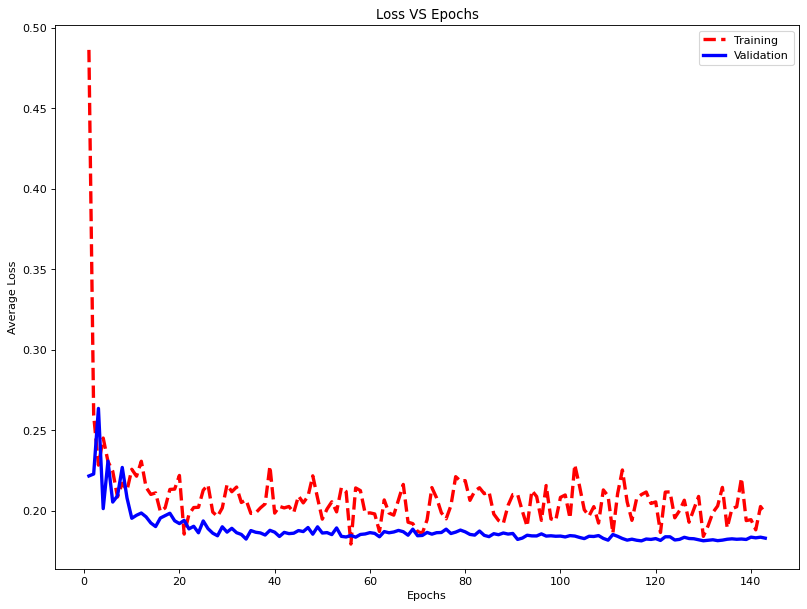

In [109]:
m2.plotLearningCurve()

In [110]:
y_pred=m2.predict(Xr_test)
MSE(yr_test,y_pred)

0.2001722249356165